# Autoencoder Pytorch Implementation

## Description

In this notebook we implemented a different latent variable models that are all members of the autoencoder model family.
An autoencoder model is an unsupervised machine learning model, which is trained on **unlabelled data**. The models are trained to compress
data $x$ from a high dimensional space $m$ to a lower dimensional space $n$. The compressed data $z$ is called a latent variable, because
it is an unobserved variable/latent/hidden, compared to the observed variable $x$. Why do we bother training models that compress and uncompress data?
To give you some intuition, we can think about the process of compression and decompression as a solution to the problem of keeping only the 
minimum necessary information to describe the entire object. We aim to make the representation space small enough, that it is challenging for 
the model to reconstruct the data, but large enough that it contains all the necessary information to achieve the task. By forcing
the model to compress the information, we force the model to distill the essential information about our data in an information rich latent representation.


### About the models and data

    1. **The MNIST dataset**
    In this notebook we are implementing different kinds of autoencoders, using the MNIST dataset, so you can get a feeling for what happens under the hood.
    The MNIST dataset basically the "hello world" of machine learning, because it is a relatively small dataset, visually interpretable and thus easy to train,
    diagnose and reason about. 

    2. **Autoencoders**
    We are going to start with a very simple autoencoder, that simply takes our data, compresses it and decompresses it. We are then going to expand the complexity
    of the models by introducing **convolutional layers** to take advantage of useful inductive biases in the data. To increase the robustness of the models we can then 
    make the task harder, by injecting noise into the data before we feed the data into the model (**Denoising Autoencoders**). Finally we are going to build a 
    **variational autoencoder** to increase the robustness of the autoencoders for data generation. All topics will be explained in more detail throughout the notebook.


Enjoy!

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import os

script_path = os.getcwd()
print(script_path)

/home/jonfunk/ML4Proteins/02_Representations


# Downloading the data


We are starting of, by downloading the data and transforming it it to a tensors.

In [2]:
# Transformations
transform = transforms.ToTensor()

# Load the MNIST dataset
mnist_data = datasets.MNIST(root='../data', train=True, download=True, transform=transform)

# Extract labels for stratified splitting
targets = mnist_data.targets.numpy()  # MNIST labels

# Perform initial stratified split for train+val and test
train_val_idx, test_idx = train_test_split(
    range(len(targets)),
    test_size=0.2,  # 20% for testing
    stratify=targets,
    random_state=42
)

# Split train+val into train and val
train_idx, val_idx = train_test_split(
    train_val_idx,
    test_size=0.25,  # 25% of train+val (or 20% of total data) for validation
    stratify=[targets[i] for i in train_val_idx],
    random_state=42
)

# Create subsets
train_data = Subset(mnist_data, train_idx)
val_data = Subset(mnist_data, val_idx)
test_data = Subset(mnist_data, test_idx)

# Create DataLoaders
train_loader = DataLoader(dataset=train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(dataset=val_data, batch_size=64, shuffle=False)
test_loader = DataLoader(dataset=test_data, batch_size=64, shuffle=False)

print(f"Train size: {len(train_loader.dataset)}, Validation size: {len(val_loader.dataset)}, Test size: {len(test_loader.dataset)}")


Train size: 36000, Validation size: 12000, Test size: 12000


## Inspecting the data

We see that the values range from 0 to 1. and it consists of hand written digits with the corresponding labels.

tensor(0.) tensor(1.)


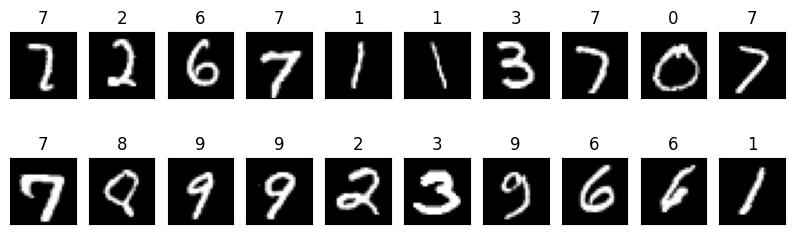

In [3]:
dataiter = iter(train_loader)
images, labels = next(dataiter)
print(torch.min(images), torch.max(images))

# Display the images
fig = plt.figure(figsize=(10, 3))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title(str(labels[idx].item()))

# Building the model (simple linear layer)

For the autoencoder we are creating a simple feed forward neural network, with linear layers and hidden layers. The initial image shape will be (N, 784), where N is our batch size. In the init method we are using the super init, which initializes the super class.

We first reduce the images with a few linear layers. To structure the code we are using a sequential model. We are creating a sequential model in which we continously apply linear layers. Remember: We noticed above, that values of the images were ranging from 0 to 1. Therefore, we need to have values from 0 to 1 as our ouput aswell. For this we are using the sigmoid function as the last activation function.

In [4]:
class Autoencoder(nn.Module):
    def __init__(self, d_z=10):
        super().__init__()
        self.d_z=d_z
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 128),    # N,784 -> N,128
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, d_z),
            nn.ReLU()
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(d_z, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 28*28),
            nn.Sigmoid()  # Sigmoid to get values between 0 and 1
        )
    
    def forward(self, x):
        x = x.view(-1, 28 * 28)
        z = self.encoder(x)
        decoded = self.decoder(z)
        return decoded.view(-1, 1, 28, 28)
    
    def encode(self, x):
        x = x.view(-1, 28 * 28)
        z = self.encoder(x)
        return z

    def generate(self, z):
        return self.decoder(z)

# Training the model

We define the number of epochs (in this case just 10 for a quick test), we create a list to store the outputs. We start the training process by iterating over the epochs and then we iterate over our data loader.

- while iterating over the data_loader, we are reshaping the images. The images are in shape 28*28 and we are reshaping them to 784.
- We then call the model and get the reconstructed image (recon)
- We thenn call the criterion with the reconstructed image and the original image (to calculate the mean squared error)
- We are then resetting our gradiends 
- We are then calling the back propagation algorithm
- Finally the optimization step

We are also printing the epoch and the loss of the epoch at every step and append the epoch, the image and the reconstructed image in the outputs list.

In [5]:
def plot_losses(train_losses, val_losses, test_loss, best_epoch, num_epochs, model_name="model"):
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
    plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
    plt.axvline(x=best_epoch + 1, color='red', linestyle='--', label='Lowest Val Loss')
    plt.scatter(best_epoch + 1, min(val_losses), color='red', zorder=5)  # Mark the point
    plt.title('Training, Validation, and Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    # Save the best model
    dest = os.path.join(script_path, f'plots/{model_name}_training_curve.png')
    if not os.path.exists(os.path.dirname(dest)):
        os.makedirs(os.path.dirname(dest), exist_ok=True)
    plt.savefig(dest)
    plt.show()

def add_noise(inputs):
    noise = (0.1)*torch.randn_like(inputs)
    return inputs + noise

def train_model(
    model, 
    train_loader, 
    val_loader, 
    test_loader, 
    criterion, 
    optimizer, 
    num_epochs, 
    device, 
    use_noise=False, 
    add_noise_fn=None, 
    model_name="model"
):
    """
    Train a model with optional noise addition and save the best weights.

    Args:
        model: The model to train (Autoencoder or VAE).
        train_loader: DataLoader for the training set.
        val_loader: DataLoader for the validation set.
        test_loader: DataLoader for the test set.
        criterion: Loss function.
        optimizer: Optimizer.
        num_epochs: Number of training epochs.
        device: Device to train on (CPU or GPU).
        use_noise: Whether to add noise to the input during training.
        add_noise_fn: Function to add noise, if use_noise=True.
        model_name: Name of the model for saving weights.

    Returns:
        train_losses, val_losses, test_loss, best_epoch
    """
    train_losses = []
    val_losses = []
    test_losses = []
    lowest_val_loss = float('inf')
    best_epoch = -1
    best_model_state = None

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        for img, _ in train_loader:
            img = img.to(device)

            noisy_img = add_noise_fn(img) if use_noise and add_noise_fn else img

            out = model(noisy_img)

            # if recon is a tuple, use the first element (VAE)
            if isinstance(out, tuple):
                recon, mu, logvar = out
                loss = criterion(recon, img, mu, logvar)
            else:
                loss = criterion(out, img) 
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_loss /= len(train_loader)
        train_losses.append(train_loss)

        # Validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for img, _ in val_loader:
                img = img.to(device)

                noisy_img = add_noise_fn(img) if use_noise and add_noise_fn else img
                
                out = model(noisy_img)
                # if out is a tuple, use the first element (VAE)
                if isinstance(out, tuple):
                    recon, mu, logvar = out
                    loss = criterion(recon, img, mu, logvar)
                else:
                    loss = criterion(out, img) 

                val_loss += loss.item()
        val_loss /= len(val_loader)
        val_losses.append(val_loss)

        if val_loss < lowest_val_loss:
            lowest_val_loss = val_loss
            best_epoch = epoch
            best_model_state = model.state_dict()

        print(f"Epoch {epoch + 1}/{num_epochs} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

    # Testing
    test_loss = 0.0
    with torch.no_grad():
        for img, _ in test_loader:
            img = img.to(device)

            noisy_img = add_noise_fn(img) if use_noise and add_noise_fn else img
            
            out = model(noisy_img)
            # if recon is a tuple, use the first element (VAE)
            if isinstance(out, tuple):
                recon, mu, logvar = out
                loss = criterion(recon, img, mu, logvar)
            else:
                loss = criterion(out, img) 
                
            test_loss += loss.item()

    test_loss /= len(test_loader)
    test_losses.append(test_loss)
    print(f"Test Loss: {test_loss:.4f}")

    dest = os.path.join(script_path, f'model_weights/{model_name}_best.pth')
    if not os.path.exists(os.path.dirname(dest)):
        os.makedirs(os.path.dirname(dest), exist_ok=True)
    torch.save(best_model_state, dest)

    return train_losses, val_losses, test_losses, best_epoch

# Setting up the model

In order to set up a model, we need a criterion to judge the performance of the model. In the case auf the encoder decoder, we are simply using mean square error loss (of the original image and the recread image).
The second thing we need is an optimizer. For the optimizer we are simply using the adam optimizer. We have to give the optimizer something to optimize, which in our case are the model parameters and we need a learning rate, which will be set to 1e-3 (0.001) in this case, and we added a weight decay, which was set to 1e-5 (0.00001)

Using cuda
Epoch 1/20 | Train Loss: 0.0606 | Val Loss: 0.0450
Epoch 2/20 | Train Loss: 0.0388 | Val Loss: 0.0342
Epoch 3/20 | Train Loss: 0.0320 | Val Loss: 0.0304
Epoch 4/20 | Train Loss: 0.0293 | Val Loss: 0.0287
Epoch 5/20 | Train Loss: 0.0279 | Val Loss: 0.0276
Epoch 6/20 | Train Loss: 0.0269 | Val Loss: 0.0268
Epoch 7/20 | Train Loss: 0.0258 | Val Loss: 0.0256
Epoch 8/20 | Train Loss: 0.0249 | Val Loss: 0.0249
Epoch 9/20 | Train Loss: 0.0241 | Val Loss: 0.0241
Epoch 10/20 | Train Loss: 0.0235 | Val Loss: 0.0236
Epoch 11/20 | Train Loss: 0.0231 | Val Loss: 0.0234
Epoch 12/20 | Train Loss: 0.0227 | Val Loss: 0.0230
Epoch 13/20 | Train Loss: 0.0224 | Val Loss: 0.0229
Epoch 14/20 | Train Loss: 0.0222 | Val Loss: 0.0223
Epoch 15/20 | Train Loss: 0.0220 | Val Loss: 0.0222
Epoch 16/20 | Train Loss: 0.0217 | Val Loss: 0.0221
Epoch 17/20 | Train Loss: 0.0216 | Val Loss: 0.0219
Epoch 18/20 | Train Loss: 0.0214 | Val Loss: 0.0217
Epoch 19/20 | Train Loss: 0.0213 | Val Loss: 0.0216
Epoch 20/2

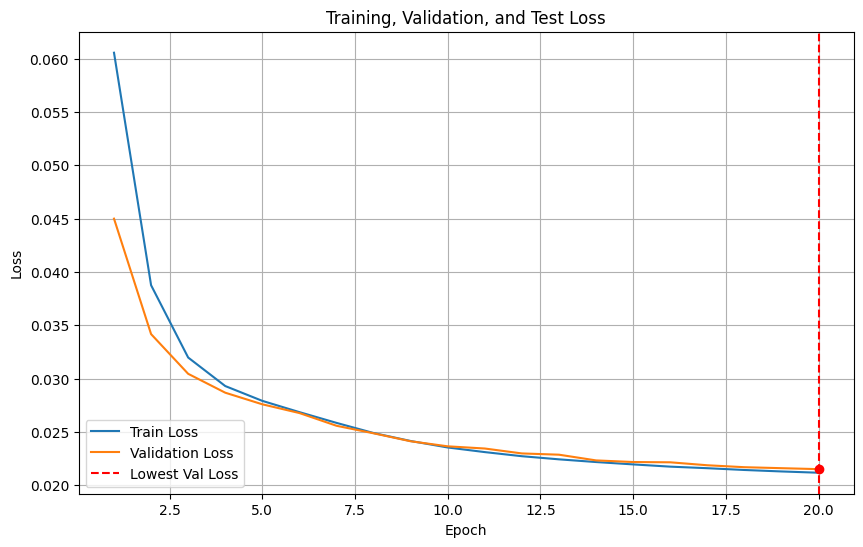

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_epochs=20

print(f"Using {device}")

d_z = 10
autoencoder = Autoencoder(d_z=d_z).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=1e-3, weight_decay=1e-5)

train_losses, val_losses, test_losses, best_epoch = train_model(
    model=autoencoder,
    train_loader=train_loader,
    val_loader=val_loader,
    test_loader=test_loader,
    criterion=nn.MSELoss(),
    optimizer=torch.optim.Adam(autoencoder.parameters(), lr=1e-3, weight_decay=1e-5),
    num_epochs=num_epochs,
    device=device,
    use_noise=False,                # Enable noise addition
    add_noise_fn=add_noise,        # Pass the noise function
    model_name="autoencoder"     # Save weights with this name
)

plot_losses(train_losses, val_losses, test_losses, best_epoch, num_epochs, model_name="autoencoder")

## Training result

We see that the loss decreased, so there is training happening. However, we also observe, that the loss is not perfectly low. To fix this we could for example increase the number of epochs.

## Inspecting the reconstructions visually

We can now take a look at the reconstructed images to see what is happening. We'll plot the images every 4 th epoch, where we get the images and the reconstructed images from the outputs array, which is a torch tensor that we have to convert back to a numpy object for plotting.

We then iterate over the images and plot the first 9 images (remember to reshape in the reverse direction from 28*28 to 28,28). Finally the images are simply plotted.

In [7]:
def visualize_reconstructions(model, data_loader, device, num_samples=9, noise=False):
    """
    Visualizes original images and their reconstructions from a trained model.

    Args:
        model: Trained autoencoder model.
        data_loader: DataLoader for the dataset to visualize.
        device: Device to perform computation (CPU or GPU).
        num_samples: Number of samples to visualize (default: 9).
    """
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():
        # Get a batch of data
        data_iter = iter(data_loader)
        images, _ = next(data_iter)
        images = images[:num_samples]  # Limit to the specified number of samples
        images = images.to(device)

        if noise:
            images = add_noise(images)

        # Generate reconstructions
        recon = model(images)

        # if recon is a tuple, use the first element (VAE)
        if isinstance(recon, tuple):
            recon = recon[0]

        # Move data to CPU for visualization
        images = images.cpu().numpy().squeeze() 
        recon = recon.cpu().numpy().squeeze() 

        # Plot original and reconstructed images
        plt.figure(figsize=(18, 4))
        plt.gray()

        for i in range(num_samples):
            # Original images
            plt.subplot(2, num_samples, i + 1)
            plt.imshow(images[i], cmap='gray')
            plt.title("Original")
            plt.axis('off')

            # Reconstructed images
            plt.subplot(2, num_samples, num_samples + i + 1)
            plt.imshow(recon[i], cmap='gray')
            plt.title("Reconstructed")
            plt.axis('off')

        plt.tight_layout()
        plt.show()

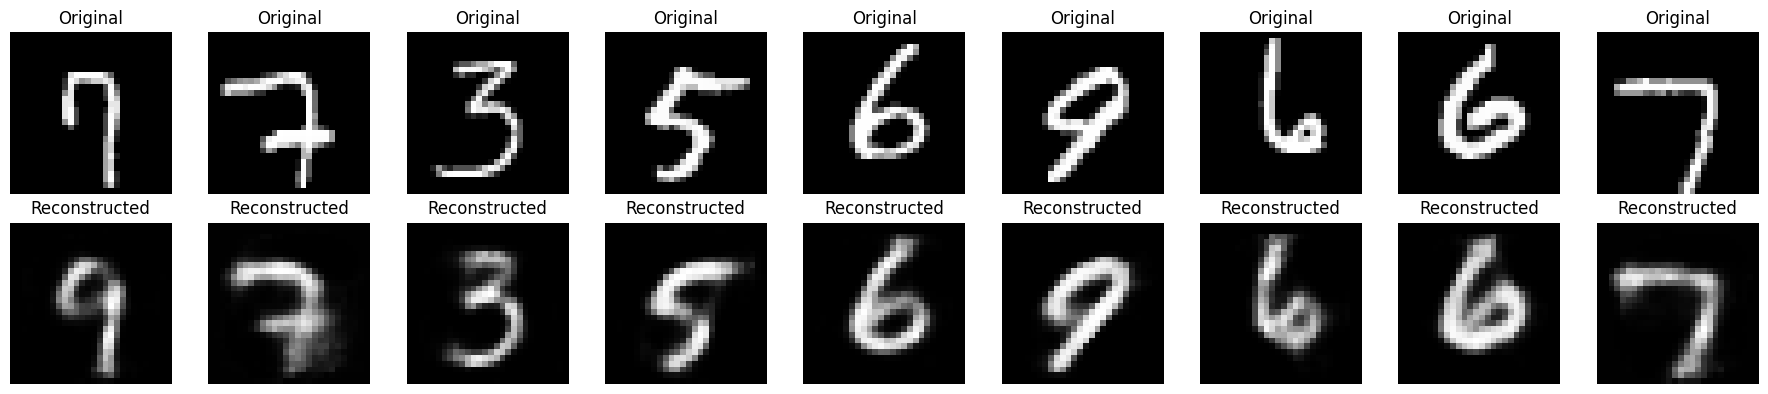

In [8]:
visualize_reconstructions(autoencoder, test_loader, device, num_samples=9)

# Building a convolutional neural network

For the convolutional neural network, we are inputing the data not as a 784 vector, but instead as a 28, 28 shaped object, just like the image. For the sequential model we now want to use Conv2d layers instead of Linear layers. The Conv2d layers expect and input channel and an output channel. We are starting with 1 input channel and just chose 16 as the first number of output channels. Additionaly the Conv2d layer expects a kernel size, which we chose to be 3, a stride which was set to 2, and we have chosen to add a padding of 1.

We start with one image with a size of 28, 28. After the first layer "1 becomes 16" and the size is reduced to 14, 14. For the next input channel, we need to use the output channel of the previous convolution. We increased the number of filters to 32. The output of the last layer will have 64 output channels, and we use a filter of the dimesion 7, 7 so the ouput size will be 1, 1 (basically one pixel, but 64 channels).

For the decoding we apply the ConvTranspose 2D layers we again need to walk backwards by matching the output dimension with the input dimensios of the encoder.

Note: Often when using convolutional neural networks, people use tha nn.MaxPool2d function, which will essentially reduce the size, to decode this you would need to use the nn.MaxUnpool2d function

In [9]:
class Autoencoder_CNN(nn.Module):
    def __init__(self, d_z=10):
        super().__init__()
        self.d_z = d_z
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1),    # N, 16, 14, 14
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),   # N, 32, 7, 7
            nn.ReLU(),
            nn.Conv2d(32, 64, 7),                       # N, 64, 1, 1
            nn.Flatten(),                               # N, 64
            nn.Linear(64, d_z)                          # N, latent_dim (d_z)
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(d_z, 64),                  # N, 64
            nn.Unflatten(1, (64, 1, 1)),                # N, 64, 1, 1
            nn.ConvTranspose2d(64, 32, 7),             # N, 32, 7, 7
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),  # N, 16, 14, 14
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1),  # N, 1, 28, 28
            nn.Sigmoid()                                # Sigmoid to get values between 0 and 1
        )
    
    def forward(self, x):
        z = self.encoder(x)
        recon = self.decoder(z)
        return recon

    def encode(self, x):
        z = self.encoder(x)
        return z
    
    def generate(self, z):
        return self.decoder(z)


# Training
We did not transform the image into a 1 dimensional vector, thats why we do not need a reshaping step in for the plotting.

Epoch 1/20 | Train Loss: 0.0575 | Val Loss: 0.0307
Epoch 2/20 | Train Loss: 0.0245 | Val Loss: 0.0218
Epoch 3/20 | Train Loss: 0.0203 | Val Loss: 0.0195
Epoch 4/20 | Train Loss: 0.0189 | Val Loss: 0.0186
Epoch 5/20 | Train Loss: 0.0182 | Val Loss: 0.0181
Epoch 6/20 | Train Loss: 0.0176 | Val Loss: 0.0176
Epoch 7/20 | Train Loss: 0.0172 | Val Loss: 0.0171
Epoch 8/20 | Train Loss: 0.0168 | Val Loss: 0.0169
Epoch 9/20 | Train Loss: 0.0165 | Val Loss: 0.0167
Epoch 10/20 | Train Loss: 0.0163 | Val Loss: 0.0165
Epoch 11/20 | Train Loss: 0.0161 | Val Loss: 0.0164
Epoch 12/20 | Train Loss: 0.0159 | Val Loss: 0.0163
Epoch 13/20 | Train Loss: 0.0157 | Val Loss: 0.0161
Epoch 14/20 | Train Loss: 0.0156 | Val Loss: 0.0159
Epoch 15/20 | Train Loss: 0.0155 | Val Loss: 0.0158
Epoch 16/20 | Train Loss: 0.0154 | Val Loss: 0.0157
Epoch 17/20 | Train Loss: 0.0154 | Val Loss: 0.0157
Epoch 18/20 | Train Loss: 0.0153 | Val Loss: 0.0155
Epoch 19/20 | Train Loss: 0.0152 | Val Loss: 0.0156
Epoch 20/20 | Train L

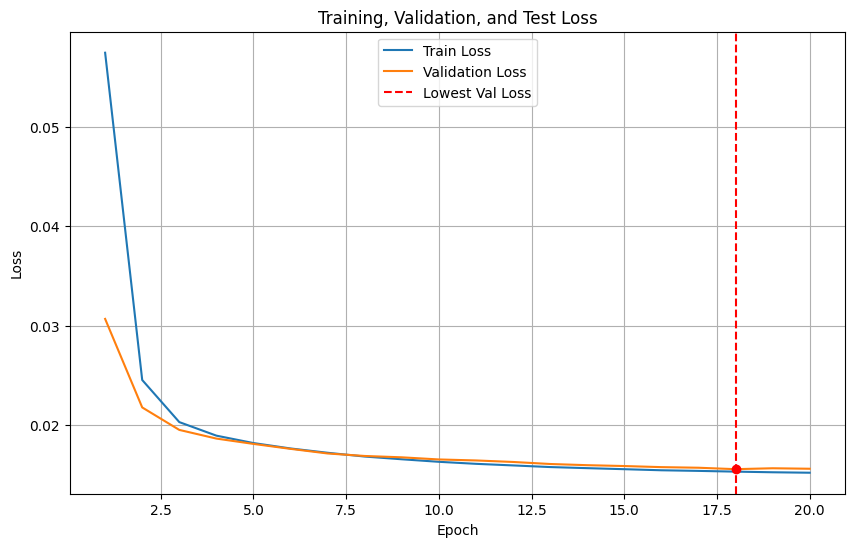

In [10]:
autoencoder_cnn = Autoencoder_CNN(d_z=10).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(autoencoder_cnn.parameters(), lr=1e-3, weight_decay=1e-5)

train_losses, val_losses, test_losses, best_epoch = train_model(
    model=autoencoder_cnn,
    train_loader=train_loader,
    val_loader=val_loader,
    test_loader=test_loader,
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=num_epochs,
    device=device,
    use_noise=False,                # Enable noise addition
    add_noise_fn=add_noise,         # Pass the noise function
    model_name="autoencoder_cnn"        # Save weights with this name
)

plot_losses(train_losses, val_losses, test_losses, best_epoch, num_epochs, model_name="autoencoder_cnn")


# CNN training results

Now we see, that the loss is way superior to the Linear Neural Networks

## CNN results visually

Here we also don't need the reshape

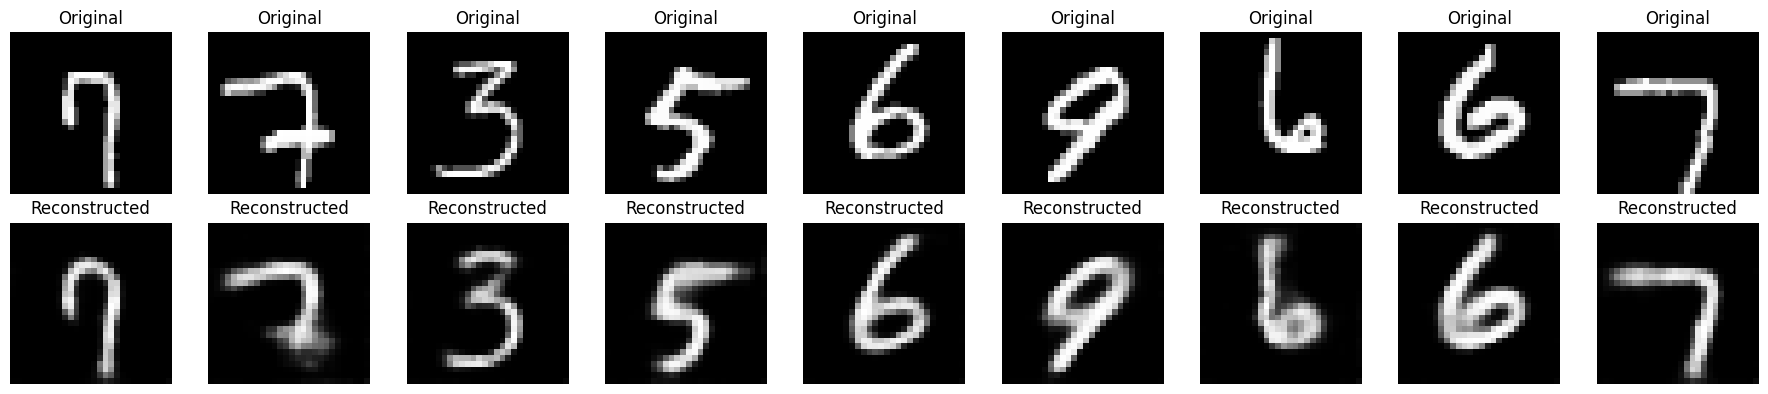

In [11]:
visualize_reconstructions(autoencoder_cnn, test_loader, device, num_samples=9)

# Denoising autoencoder

When adding noise to an image before it passes through the first layers of the autoencoder,the autoencoder is forced to pick up the patterns rather, and can not just compress the image down and scale it back up again. For the denoising autoencoder we need a function that adds noise to the output.

## Visualizing noisy images

we added noise from 1 to 0 which we mutiplied by 0.1, giving uns noise in the range of .1 to 0.

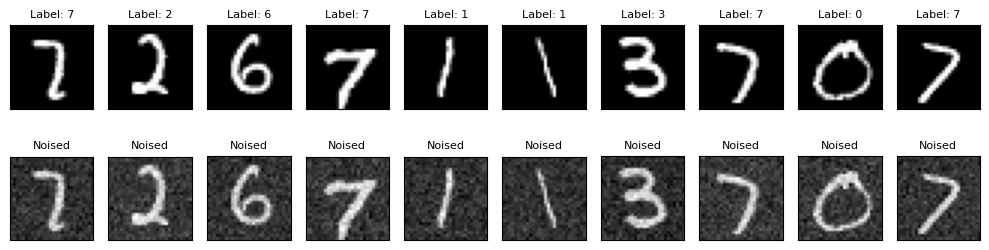

In [12]:
# Apply noise to the original images
noised_images = add_noise(images)

# Display the images
fig = plt.figure(figsize=(10, 3))
plt.gray()

# Plot original images
for idx in np.arange(10):
    ax = fig.add_subplot(2, 10, idx + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx].cpu().numpy()), cmap='gray')
    ax.set_title(f"Label: {labels[idx].item()}", fontsize=8)

# Plot noised images
for idx in np.arange(10):
    ax = fig.add_subplot(2, 10, 10 + idx + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(noised_images[idx].cpu().numpy()), cmap='gray')
    ax.set_title(f"Noised", fontsize=8)

plt.tight_layout()
plt.show()

## Building a denoising CNN autoencoder

For the denoising Autoencoder we are just reusing the CNN autoencoder, the difference will be in the training process.

## Training the denoiser CNN

for the denoiser neural network we add noise to an image before it enters the neural network. However, the quality of the output will be judged how well the network reproduced the original image, without the noise.

Epoch 1/20 | Train Loss: 0.0549 | Val Loss: 0.0280
Epoch 2/20 | Train Loss: 0.0234 | Val Loss: 0.0213
Epoch 3/20 | Train Loss: 0.0200 | Val Loss: 0.0194
Epoch 4/20 | Train Loss: 0.0187 | Val Loss: 0.0185
Epoch 5/20 | Train Loss: 0.0179 | Val Loss: 0.0179
Epoch 6/20 | Train Loss: 0.0174 | Val Loss: 0.0173
Epoch 7/20 | Train Loss: 0.0170 | Val Loss: 0.0173
Epoch 8/20 | Train Loss: 0.0168 | Val Loss: 0.0169
Epoch 9/20 | Train Loss: 0.0165 | Val Loss: 0.0166
Epoch 10/20 | Train Loss: 0.0164 | Val Loss: 0.0166
Epoch 11/20 | Train Loss: 0.0162 | Val Loss: 0.0164
Epoch 12/20 | Train Loss: 0.0161 | Val Loss: 0.0163
Epoch 13/20 | Train Loss: 0.0160 | Val Loss: 0.0163
Epoch 14/20 | Train Loss: 0.0159 | Val Loss: 0.0162
Epoch 15/20 | Train Loss: 0.0159 | Val Loss: 0.0161
Epoch 16/20 | Train Loss: 0.0158 | Val Loss: 0.0159
Epoch 17/20 | Train Loss: 0.0157 | Val Loss: 0.0160
Epoch 18/20 | Train Loss: 0.0157 | Val Loss: 0.0159
Epoch 19/20 | Train Loss: 0.0156 | Val Loss: 0.0159
Epoch 20/20 | Train L

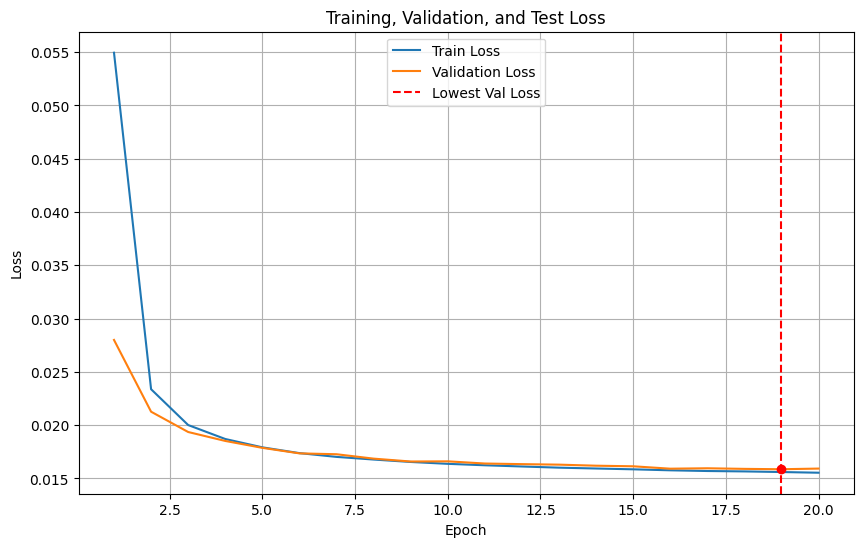

In [13]:
denoiser = Autoencoder_CNN(d_z=10).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(denoiser.parameters(), lr=1e-3, weight_decay=1e-5)

train_losses, val_losses, test_losses, best_epoch = train_model(
    model=denoiser,
    train_loader=train_loader,
    val_loader=val_loader,
    test_loader=test_loader,
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=num_epochs,
    device=device,
    use_noise=True,                # Enable noise addition
    add_noise_fn=add_noise,         
    model_name="denoiser"        
)

plot_losses(train_losses, val_losses, test_losses, best_epoch, num_epochs, model_name="denoiser")


## Visual results of denoiser CNN

We can observe, that the loss did not get as low as in the no noise case, but thre results still look very good. Adding more epochs could lead to further improvements.

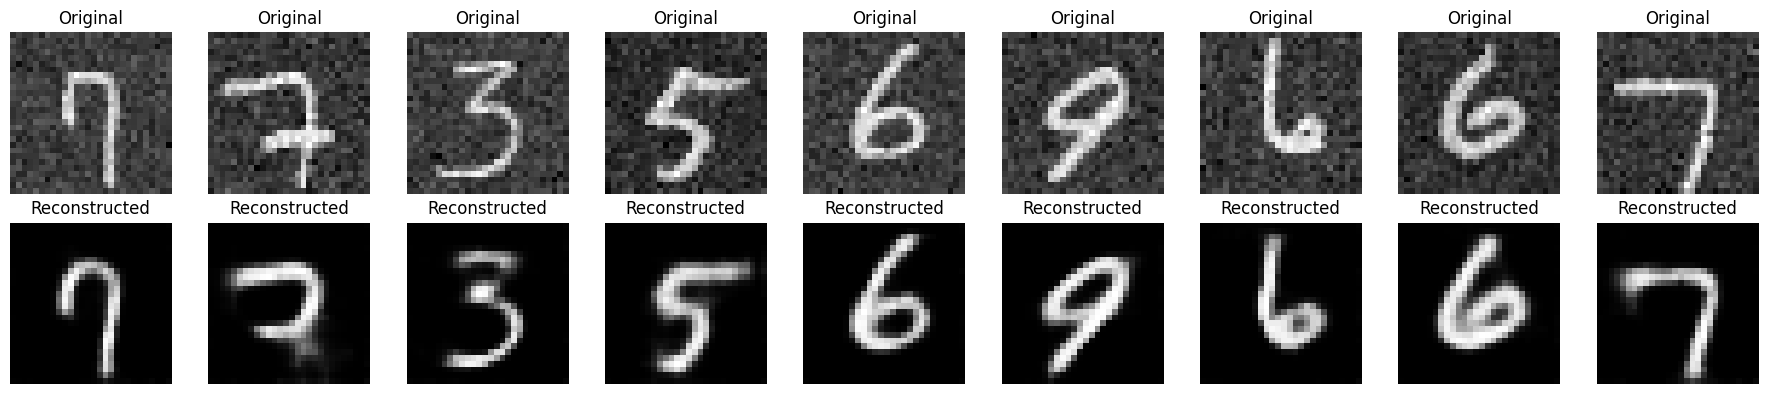

In [14]:
visualize_reconstructions(denoiser, test_loader, device, num_samples=9, noise=True)

# Variational Autoencoders (VAEs)

In [15]:
from torch.distributions import Normal, kl_divergence

class VAE(nn.Module):
    def __init__(self, d_z=10):
        super().__init__()
        self.d_z = d_z
        
        # Encoder
        self.encoder_conv = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1),    # N, 16, 14, 14
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),   # N, 32, 7, 7
            nn.ReLU(),
            nn.Conv2d(32, 64, 7),                       # N, 64, 1, 1
            nn.ReLU(),
            nn.Flatten()                                # N, 64
        )
        self.fc_mu = nn.Linear(64, d_z)          # Mean of the latent distribution
        self.fc_logvar = nn.Linear(64, d_z)      # Log-variance of the latent distribution
        
        # Decoder
        self.fc_decode = nn.Linear(d_z, 64)      # N, 64
        self.decoder_conv = nn.Sequential(
            nn.Unflatten(1, (64, 1, 1)),                # N, 64, 1, 1
            nn.ConvTranspose2d(64, 32, 7),             # N, 32, 7, 7
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),  # N, 16, 14, 14
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1),  # N, 1, 28, 28
            nn.Sigmoid()                                # Sigmoid to get values between 0 and 1
        )
    
    def reparameterize(self, mu, logvar):
        """Reparameterization trick: sample z ~ N(mu, sigma^2)."""
        std = torch.exp(0.5 * logvar)                  # Standard deviation
        eps = torch.randn_like(std)                   # Random noise
        return mu + eps * std                          # Reparameterized sample
    
    def forward(self, x):
        # Encoding
        encoded = self.encoder_conv(x)
        mu = self.fc_mu(encoded)
        logvar = self.fc_logvar(encoded)
        
        # Sampling z
        z = self.reparameterize(mu, logvar)
        
        # Decoding
        reconstructed = self.decoder_conv(self.fc_decode(z))
        return reconstructed, mu, logvar

    def encode(self, x):
        # Encoding
        encoded = self.encoder_conv(x)
        mu = self.fc_mu(encoded)
        logvar = self.fc_logvar(encoded)
        
        # Sampling z
        z = self.reparameterize(mu, logvar)
        return z

    def generate(self, z):
        return self.decoder_conv(self.fc_decode(z))
    
    def loss(self, reconstructed, x, mu, logvar):
        # Reconstruction loss (Binary Cross-Entropy)
        recon_loss = nn.functional.binary_cross_entropy(reconstructed, x, reduction="sum")
        
        # KL divergence
        q_z = Normal(mu, torch.exp(0.5 * logvar))      # Learned distribution
        p_z = Normal(torch.zeros_like(mu), torch.ones_like(mu))  # Standard normal prior
        kl_loss = kl_divergence(q_z, p_z).sum()
        
        return recon_loss + kl_loss


Epoch 1/30 | Train Loss: 12306.6797 | Val Loss: 9168.8106
Epoch 2/30 | Train Loss: 8655.0439 | Val Loss: 8329.0973
Epoch 3/30 | Train Loss: 8148.2275 | Val Loss: 8052.1753
Epoch 4/30 | Train Loss: 7972.1140 | Val Loss: 7910.8429
Epoch 5/30 | Train Loss: 7774.4356 | Val Loss: 7708.9703
Epoch 6/30 | Train Loss: 7591.3497 | Val Loss: 7590.2738
Epoch 7/30 | Train Loss: 7511.3863 | Val Loss: 7515.9598
Epoch 8/30 | Train Loss: 7461.8718 | Val Loss: 7503.2440
Epoch 9/30 | Train Loss: 7420.7375 | Val Loss: 7431.3585
Epoch 10/30 | Train Loss: 7394.2624 | Val Loss: 7396.4253
Epoch 11/30 | Train Loss: 7364.4555 | Val Loss: 7385.1365
Epoch 12/30 | Train Loss: 7336.6653 | Val Loss: 7373.0807
Epoch 13/30 | Train Loss: 7319.4193 | Val Loss: 7356.1101
Epoch 14/30 | Train Loss: 7302.9452 | Val Loss: 7336.0178
Epoch 15/30 | Train Loss: 7290.2246 | Val Loss: 7344.1009
Epoch 16/30 | Train Loss: 7269.0429 | Val Loss: 7343.8725
Epoch 17/30 | Train Loss: 7257.8663 | Val Loss: 7291.6279
Epoch 18/30 | Train Lo

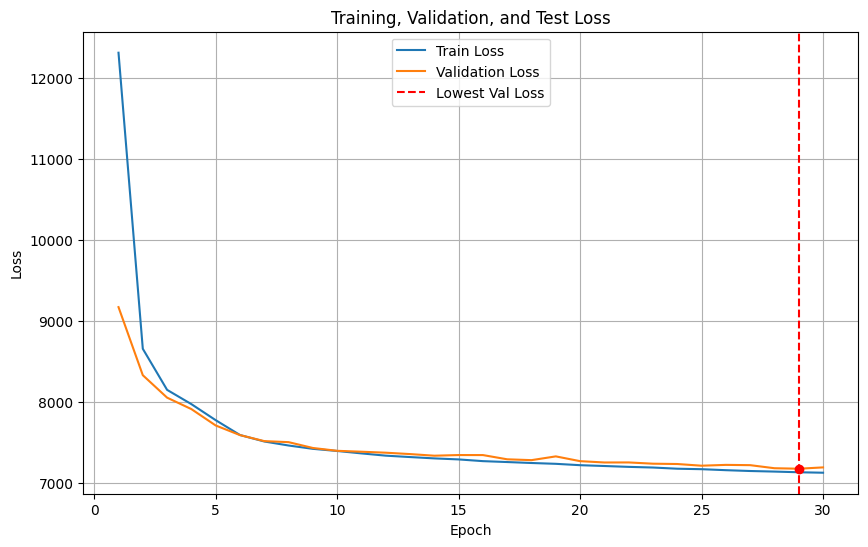

In [20]:
vae = VAE(d_z=10).to(device)
criterion = vae.loss
optimizer = torch.optim.Adam(vae.parameters(), lr=1e-3, weight_decay=1e-5)
num_epochs = 30

train_losses, val_losses, test_losses, best_epoch = train_model(
    model=vae,
    train_loader=train_loader,
    val_loader=val_loader,
    test_loader=test_loader,
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=num_epochs,
    device=device,
    use_noise=True,                # Enable noise addition
    add_noise_fn=add_noise,         
    model_name="vae"        
)

plot_losses(train_losses, val_losses, test_losses, best_epoch, num_epochs, model_name="vae")


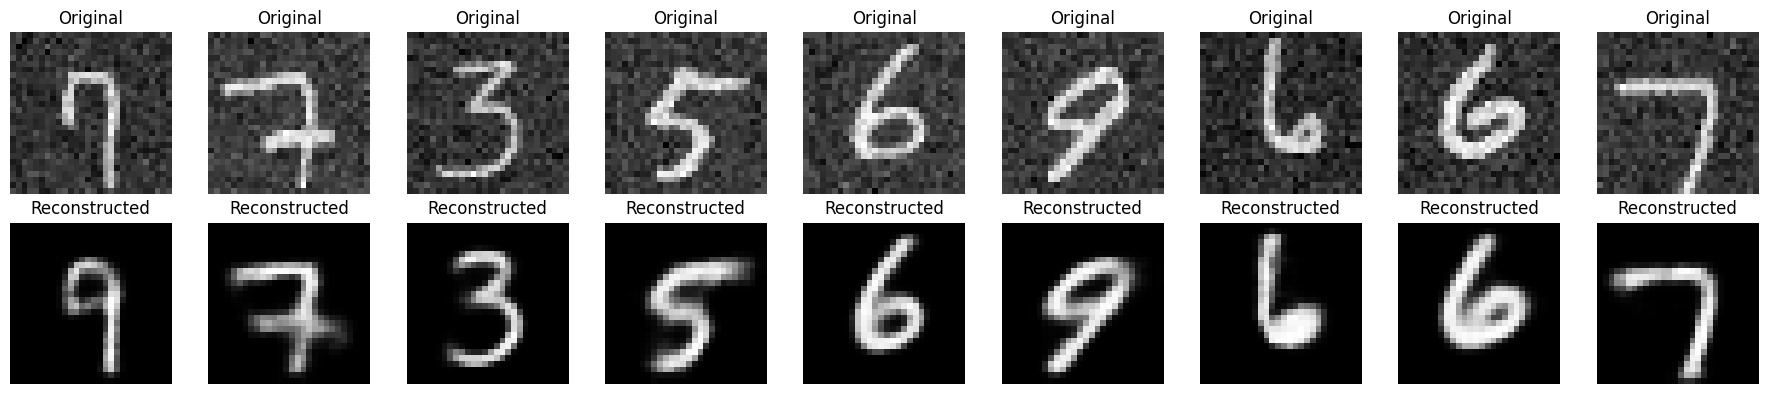

In [21]:
visualize_reconstructions(vae, test_loader, device, num_samples=9, noise=True)

# Comparing Latent Spaces and Generative Capabilities

In this section, we compare the latent spaces learned by the autoencoders and their generative capabilities.

## Latent Space Comparison

Latent space comparison involves encoding a shared dataset (e.g., the MNIST test set) into the latent spaces of each autoencoder. We visualize these latent spaces using dimensionality reduction techniques like t-SNE or UMAP to understand the structure and separability of the encoded representations.

## Generative Capability Comparison

Generative capability comparison involves using the `generate` function of each autoencoder to produce samples. We qualitatively assess the fidelity and diversity of these generated samples.


/home/jonfunk/miniforge3/envs/proteusAI/lib/python3.8/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


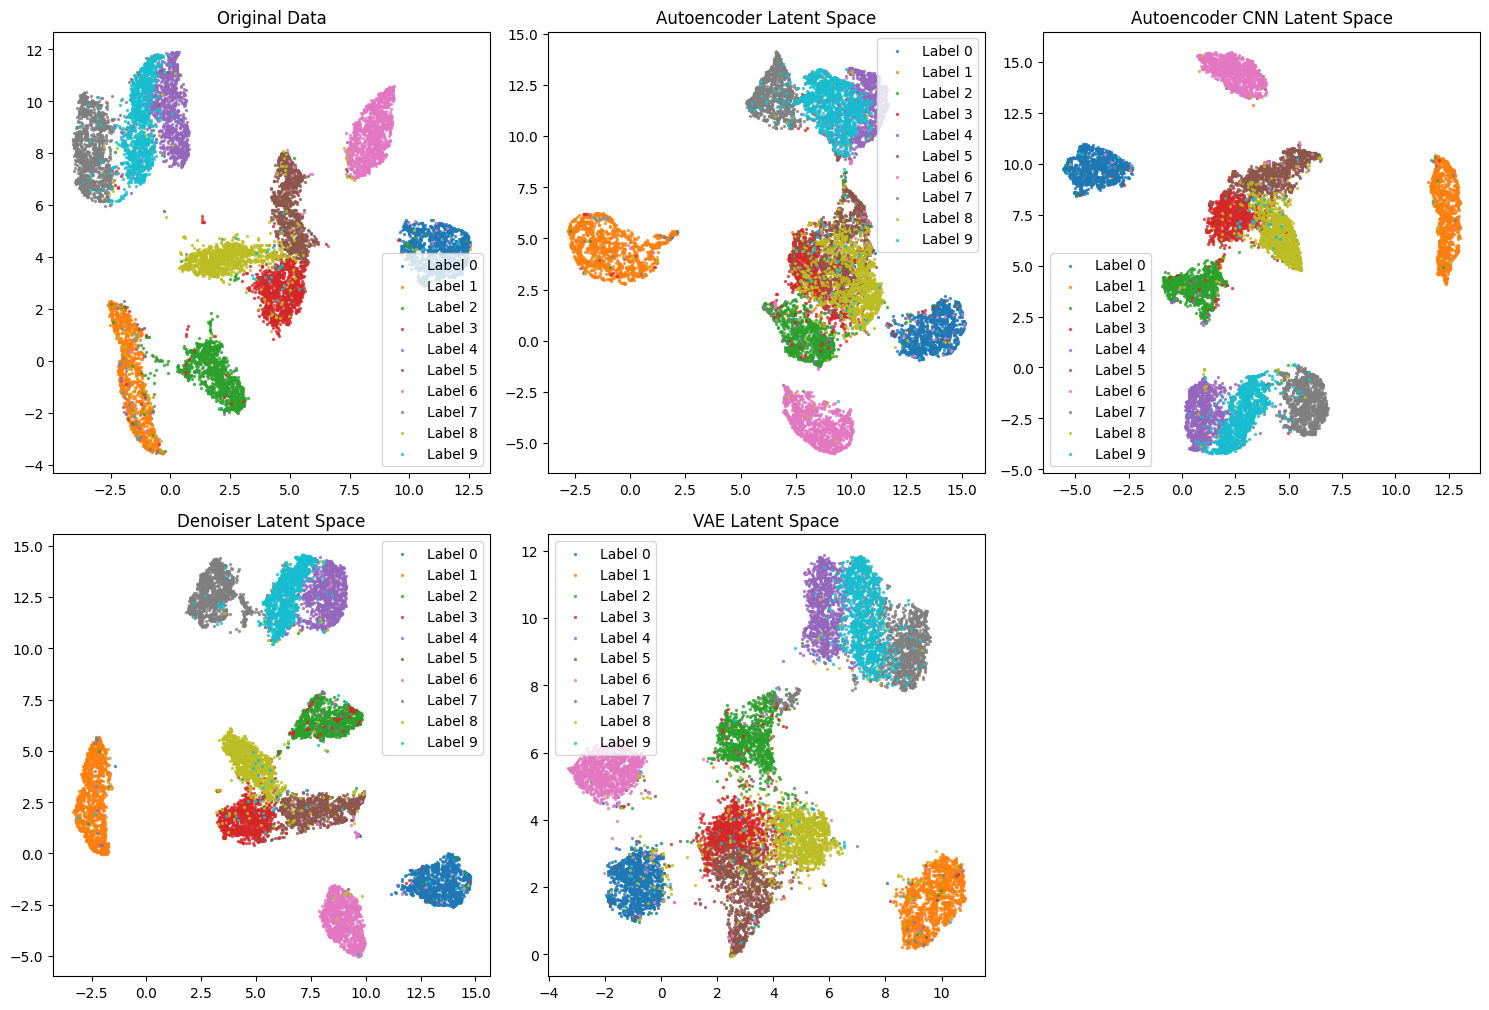

In [22]:
from umap import UMAP
import torch
import matplotlib.pyplot as plt

# Dictionary of models
autoencoders = {
    "Autoencoder": autoencoder,
    "Autoencoder CNN": autoencoder_cnn,
    "Denoiser": denoiser,
    "VAE": vae
}

# Collect images and labels
test = [(img,label) for img, label in test_loader.dataset]
imgs = torch.stack([img for img, _ in test], dim=0)
labels = torch.tensor([label for _, label in test])

# Encode data using each model
encoded_data = {}
for model_name, model in autoencoders.items():
    encoded_data[model_name] = model.encode(imgs.to(device)).cpu().detach().numpy()

# Apply UMAP to the original data
original_data = imgs.view(imgs.size(0), -1).numpy()  # Flatten the images
umap = UMAP(n_components=2, random_state=42)
original_data_2D = umap.fit_transform(original_data)

# Apply UMAP to the latent spaces
latent_spaces_2D = {name: umap.fit_transform(data) for name, data in encoded_data.items()}

# Plot the UMAP results
plt.figure(figsize=(15, 15))

# Plot for unencoded data
plt.subplot(3, len(latent_spaces_2D) // 2 + 1, 1)
for label in torch.unique(labels):
    indices = (labels == label).numpy()
    plt.scatter(original_data_2D[indices, 0], original_data_2D[indices, 1], s=2, label=f"Label {label.item()}", alpha=0.7)
plt.title("Original Data")
plt.legend()
plt.tight_layout()

# Plot for latent spaces
for i, (name, latent_2D) in enumerate(latent_spaces_2D.items(), start=2):
    plt.subplot(3, len(latent_spaces_2D) // 2 + 1, i)
    for label in torch.unique(labels):
        indices = (labels == label).numpy()
        plt.scatter(latent_2D[indices, 0], latent_2D[indices, 1], s=2, label=f"Label {label.item()}", alpha=0.7)
    plt.title(f"{name} Latent Space")
    plt.legend()
    plt.tight_layout()

plt.show()

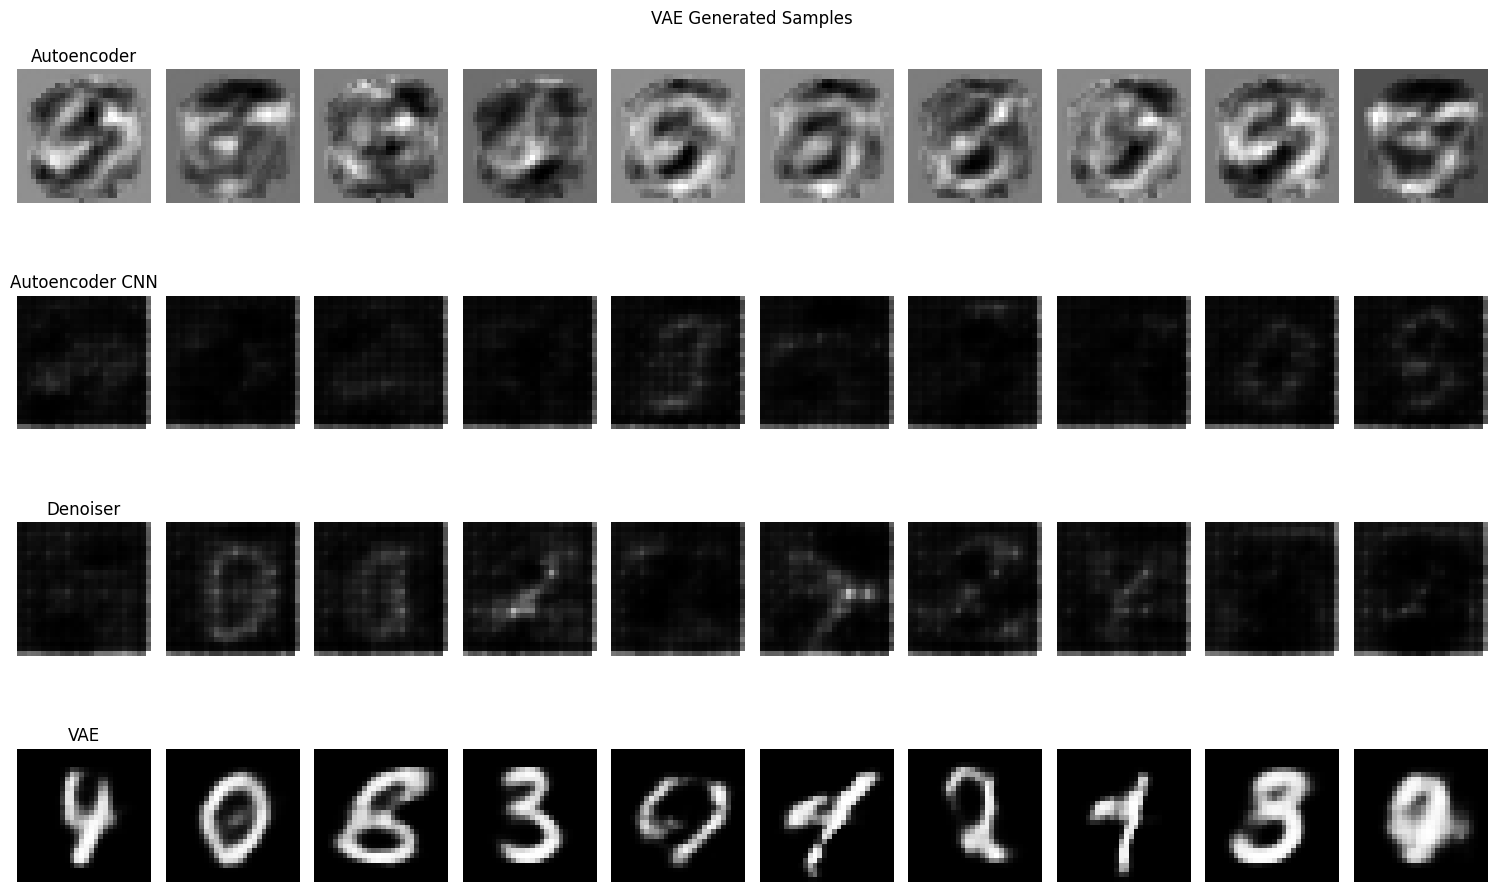

In [23]:
num_samples = 10

# Generate new samples using each autoencoder's `generate` function
generated_samples = {}
for model_name, model in autoencoders.items():
    # Sample latent vectors from a standard normal distribution
    d_z = model.d_z
    z = np.random.multivariate_normal(mean=np.zeros(d_z), cov=np.eye(d_z), size=num_samples)
    
    # Generate samples from the latent space
    generated_samples[model_name] = model.generate(torch.tensor(z, dtype=torch.float32).to(device))

# Visualize generated samples
plt.figure(figsize=(15, 10))
for i, (name, samples) in enumerate(generated_samples.items()):
    for j, sample in enumerate(samples.cpu().detach().numpy()):
        plt.subplot(len(generated_samples), 10, i * 10 + j + 1)
        plt.imshow(sample.reshape(28, 28), cmap="gray")  # Reshape to (28, 28) for visualization
        plt.axis("off")
        if j == 0:
            # center title for each row
            plt.title(name)

    plt.suptitle(f"{name} Generated Samples", y=0.95)
plt.tight_layout()
plt.show()

# Final notes
Here we can see the true importance of imposing regularizations of on the latent space. If we try to use the different autoencoders for data generation 
the VAE is the only viable option. Let's take a moment to reflect about why that is.

Regular autoencoders are only encouraged to compress data to some arbitrary latent space. However, the model is not incentivised to create the latent space
in a particular region in the vector space it creates. That means that the distances for latent representations of different digits might be placed far appart
and the model does not really care about their relative position. A VAE on the other hand forces the latent space to stay within a desired region, in our case
normally distributed around the origin. When we want to generate new data, this now gives us the freedom to simply sample random vectors from that region and 
send them through the decoder and we can expect reasonable results! I helped you to build an intuition why latent space geometry matters, and what the implications
of the a good or bad geometry can be.